---

# **1. Model for cropping the image for a future fruit defining**

# Library Imports and Environment Setup

### This block of imports provides all the necessary tools for setting up an efficient image classification and segmentation pipeline. The combination of TensorFlow/Keras for deep learning, OpenCV for computer vision tasks, and Scikit-Learn for dataset handling ensures that you can load, preprocess, and train models for both image segmentation and classification. Visualization tools like Matplotlib further help in assessing the performance visually.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

## Dataset Loading and Preprocessing

### This section defines parameters for the dataset and includes a function for loading and preprocessing the FruitSeg30 dataset. It handles loading the dataset from disk, checking for necessary files (images and masks), and ensuring they are in the correct format and size for use in model training. By normalizing the images and masks, the model will be able to process them efficiently, and the checks for missing files help ensure that incomplete data does not interfere with training.

In [2]:
# Parameters
IMAGE_SIZE = (128, 128)  # Image dimensions (can be adjusted)
DATASET_DIR = './FruitSeg30/FruitSeg30'  # Path to the dataset folder

def load_fruitseg_data(dataset_dir, image_size=(128, 128)):
    """
    Load FruitSeg30 dataset from the specified directory.
    Args:
        dataset_dir (str): Path to the FruitSeg30 folder.
        image_size (tuple): Desired image size (width, height).

    Returns:
        images (list): List of images.
        masks (list): List of masks.
        
    """
    images = []  # To store images
    masks = []   # To store masks
    
    # Iterate through each fruit folder
    for fruit_class in os.listdir(dataset_dir):
        fruit_path = os.path.join(dataset_dir, fruit_class)
        
        # Check if the folders 'images' and 'masks' exist
        image_dir = os.path.join(fruit_path, 'Images')
        mask_dir = os.path.join(fruit_path, 'Mask')
        if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
            print(f"Skipped folder {fruit_class} as 'images' or 'masks' are missing.")
            continue
        
        # Process images in the folder
        for img_file in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_file)
            
            # Generate mask filename by appending '_mask' before the extension
            # For example, 'apple_001.png' -> 'apple_001_mask.png'
            mask_file = os.path.splitext(img_file)[0] + "_mask.png"
            mask_path = os.path.join(mask_dir, mask_file)
            
            # Check if the corresponding mask exists
            if not os.path.exists(mask_path):
                print(f"Skipped file {img_file} as corresponding mask {mask_file} is missing.")
                continue
            
            # Load the image and mask
            img = load_img(img_path, target_size=image_size)
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
            
            # Convert to arrays
            images.append(img_to_array(img) / 255.0)  # Normalize images
            masks.append(img_to_array(mask) / 255.0)  # Normalize masks (0 or 1)
    
    # Convert to numpy arrays
    return np.array(images), np.array(masks)

# Load data
images, masks = load_fruitseg_data(DATASET_DIR, IMAGE_SIZE)

# Check dimensions
print(f"Number of images: {len(images)}")
print(f"Image dimensions: {images[0].shape}")
print(f"Mask dimensions: {masks[0].shape}")


Number of images: 1969
Image dimensions: (128, 128, 3)
Mask dimensions: (128, 128, 1)


### Data Splitting into Training and Validation Sets ensuring that the model has a distinct set of data for training and evaluation during the training process.

In [3]:
# Splitting data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training set size: {x_train.shape}, {y_train.shape}")
print(f"Validation set size: {x_val.shape}, {y_val.shape}")


Training set size: (1575, 128, 128, 3), (1575, 128, 128, 1)
Validation set size: (394, 128, 128, 3), (394, 128, 128, 1)


## U-Net Model Definition for Image Segmentation

### Section defines the architecture of a `U-Net` model used for image segmentation. `U-Net` is a type of convolutional neural network (CNN) that is specifically designed for image segmentation tasks, especially in medical image processing or any task requiring pixel-wise predictions. The model follows an encoder-decoder structure, which allows it to capture both high-level features (through the encoder) and fine-grained spatial details (through the decoder).

In [6]:
def unet_model(input_shape=(128, 128, 3)):
    """
    Define the U-Net model.
    Args:
        input_shape (tuple): The shape of the input image.

    Returns:
        tf.keras.Model: The U-Net model.
    """
    inputs = tf.keras.Input(input_shape)

    # Encoder layers
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck layer 
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder layers
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return tf.keras.Model(inputs=[inputs], outputs=[outputs])

model = unet_model(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

### Sets up the training process for the `U-Net` model, utilizing an early stopping callback to prevent overfitting and ensure efficient training. The model is trained on the segmented fruit images and their corresponding masks, using the previously defined `U-Net` architecture.
### This shows the following metrics for the final epoch:
### Training Accuracy: 69.98%
### Training Loss: 0.0990
### Validation Accuracy: 69.78%
### Validation Loss: 0.1013

In [7]:
# Define callbacks for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/20


C:\Users\Elina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:229: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=type(Tensor("data:0", shape=(None, 128, 128, 3), dtype=float32))
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 533s 5s/step - accuracy: 0.6493 - loss: 0.4753 - val_accuracy: 0.6769 - val_loss: 0.2506
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.6762 - loss: 0.1878 - val_accuracy: 0.6565 - val_loss: 0.2063
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.6799 - loss: 0.2332 - val_accuracy: 0.6775 - val_loss: 0.1941
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - accuracy: 0.6844 - loss: 0.1717 - val_accuracy: 0.6757 - val_loss: 0.1838
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 563s 6s/step - accuracy: 0.6878 - loss: 0.1556 - val_accuracy: 0.6776 - val_loss: 0.1822
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.6821 - loss: 0.1616 - val_accuracy: 0.6795 - val_loss: 0.1805
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 565s 6s/step - accuracy: 0.6873 - loss: 0.1634 - val_accuracy: 0.6814 - val_loss: 0.1799
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 537s 5s/step - accuracy: 0.6900 - loss: 0.1541 - val_accuracy: 0.6812 - val_loss: 0.

In [8]:
model_save_path = "./unet_fruit_segmentation_model.h5"
model.save(model_save_path)
print(f"Модель сохранена по пути: {model_save_path}")

Модель сохранена по пути: ./unet_fruit_segmentation_model.h5


## Training and Validation Visualization

### In the left graph, we can observe how the accuracy of the model is increasing on both the training and validation datasets. Both accuracies increase ambiguously, with occasional drops, but ultimately, they reach a fairly high level at approximately 0.69 for the model.
### In the right graph, we can observe how the loss of the model is decreasing on both the training and validation datasets. Both losses decrease ambiguously, with occasional drops, but ultimately, they reach a fairly low level at approximately 0.1 for the model.

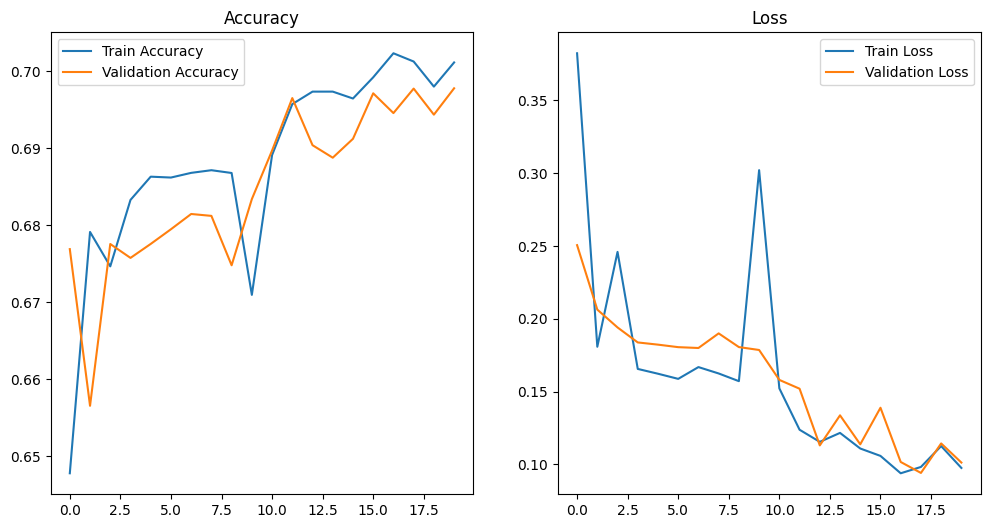

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


### Here we visualize the performance of the trained U-Net model on a sample image from the validation dataset by comparing the original image, the true mask, and the predicted mask. This helps to assess how well the model performs on unseen data.
### Expected Output:
- The **original image** will display the fruit or object of interest.
- The **true mask** will highlight the object (typically in white) against a black background.
- The **predicted mask** should be compared to the true mask to see how accurately the model has predicted the object segmentation. Minor errors in segmentation could occur, such as small mismatches in boundaries, but overall accuracy should be visible if the model is performing well.

C:\Users\Elina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:229: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=type(Tensor("data:0", shape=(1, 128, 128, 3), dtype=float32))
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


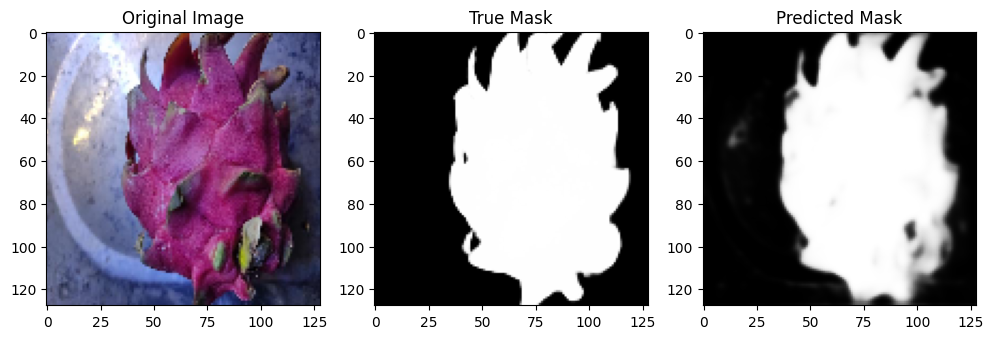

In [10]:
# Prediction
idx = 0  # Change this index to visualize different images
predicted_mask = model.predict(np.expand_dims(x_val[idx], axis=0))[0]

# Visualize the original image, true mask, and predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(x_val[idx])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_val[idx].squeeze(), cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.show()


# Improving mask

### The purpose of smoothing is to reduce noise in the mask, making the object boundaries smoother and less jagged.

In [7]:
def smooth_mask(mask):
    """
    Smooth the mask using Gaussian blur to reduce noise.
    Args:
    - mask: The binary mask to be smoothed.

    Returns:
    - The smoothed mask.
    """
    return cv2.GaussianBlur(mask, (7, 7), 0)

## Image processing steps: 
- smoothing, 
- thresholding, 
- dilation, 
- erosion. 
### These operations help enhance the quality of the mask, reduce noise, and fill gaps in the segmented areas.

In [8]:
def improve_mask(mask):
    """
    Improve the mask by smoothing and thresholding.
    Parameters:
    - mask: The input mask.

    Returns:
    - improved_mask
    """
    # Smoothing the mask to reduce noise
    smoothed_mask = smooth_mask(mask)
    
    # Thresholding the smoothed mask to obtain binary mask 
    _, thresholded_mask = cv2.threshold(smoothed_mask, 0.5, 1.0, cv2.THRESH_BINARY)
    
    # Dilate the thresholded mask to fill in gaps and improve the mask quality
    dilated_mask = cv2.dilate(thresholded_mask.astype(np.uint8), np.ones((7, 7), np.uint8), iterations=2)
    
    # Erode the dilated mask to remove small artifacts and refine the mask quality
    eroded_mask = cv2.erode(dilated_mask, np.ones((7, 7), np.uint8), iterations=1)
    
    return eroded_mask

In [9]:
def apply_mask(image, mask):
    """
    Apply a mask to an image.
    Parameters:
    - image: numpy array, the input image
    - mask: numpy array, the mask to apply

    Returns:
    - numpy array, the image with the mask applied
    """

    # Adjust mask size to match the image dimensions
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Apply morphological processing to the mask
    refined_mask = improve_mask(mask_resized)

    # Convert the mask to 3 channels for application to the image
    mask_rgb = np.stack([refined_mask] * 3, axis=-1)

    # Enhance mask contrast: darken the background and highlight the fruits
    # First, make the background completely dark (black) and the fruits white
    enhanced_mask = np.where(refined_mask == 1, 1, 0)  # Fruits in white, background in black
    
    # Apply the mask: fruits remain colorful, background darkens
    result_image = image * np.expand_dims(enhanced_mask, axis=-1)  # Retain fruits, background turns black
    
    return result_image


In [10]:
def process_image_with_mask(image_path, model):
    """
    Processes an image with a mask.
    Args:
        image_path (str): Path to the image file.
        model (keras.Model): The model to use for processing.
    Returns:
        numpy.ndarray: The processed image.
        numpy.ndarray: The predicted mask.
    """

    # Load the image and prepare it for the model
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get the mask from the model
    pred_mask = model.predict(img_array)[0]
    
    # Apply the enhanced mask to the image
    original_img = img_to_array(load_img(image_path))  # Load the original image
    final_image = apply_mask(original_img, pred_mask)
    
    return final_image, pred_mask


## Expected Outcome:
- **Original Image**: You will see the raw input image (banana in this case).
- **Refined Mask**: This mask highlights the areas of the image that the model has segmented as the object of interest (likely the banana).
- **Final Image with Mask Applied**: The final result will show the banana in its original color with the background turned black (darkened).

## Example (If the input image is a banana, the output should display):
- The original banana image.
- The refined mask, where the banana is white (masked) and the background is black.
- The final image, where only the banana is visible in full color, and the background is blacked out.

## This visualization workflow is useful for evaluating segmentation model performance and visualizing results clearly.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


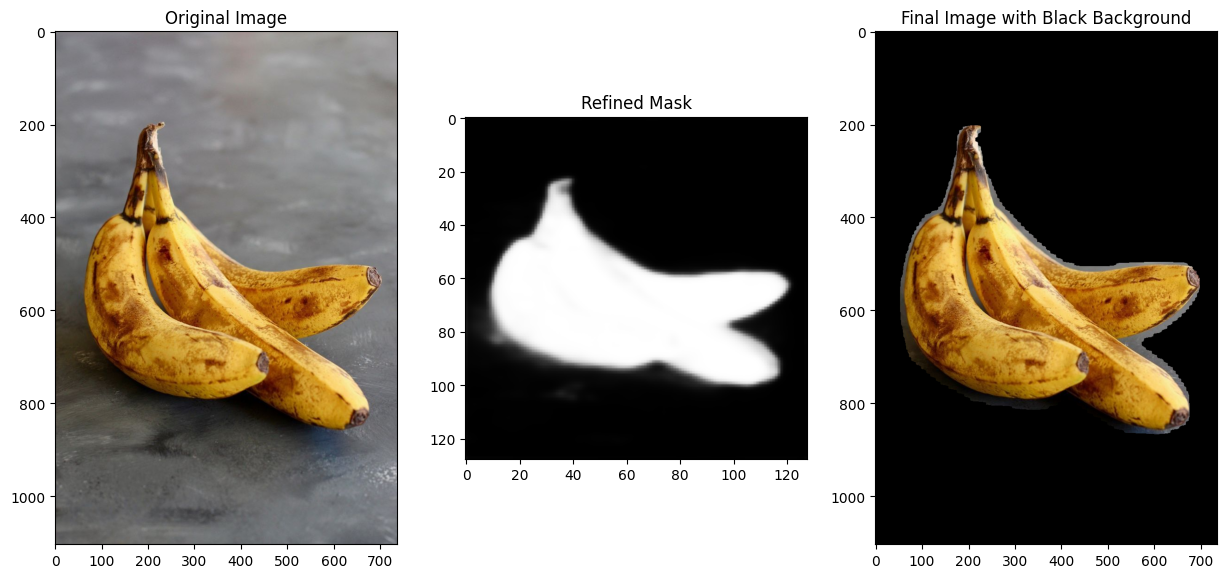

In [16]:
image_path = './foto_test/banana.jpg'
final_image, refined_mask = process_image_with_mask(image_path, model)

# Display the results
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(load_img(image_path))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(refined_mask.squeeze(), cmap='gray')
plt.title('Refined Mask')

plt.subplot(1, 3, 3)
plt.imshow(final_image.astype(np.uint8))
plt.title('Final Image with Black Background')
plt.show()

-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
# **2. Model for Recognition**

### This script uses several essential libraries for building and training an image recognition model:

- **PyTorch** (`torch`, `torch.nn`, `torch.optim`) for deep learning model creation, training, and optimization.
- **torchvision** for datasets, pre-trained models, and image transformations.
- **DataLoader** for batch processing of data.
- **PIL** and **matplotlib** for image manipulation and visualization.
- **tqdm** for progress bars during training.

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from tqdm import tqdm
from PIL import Image

# Data Transformations

### This section defines a set of image transformations applied to the dataset during training, validation, and testing.

- **Training Data**:
  - The training dataset undergoes various augmentations like random cropping, flipping, and rotation to increase diversity and improve the model's robustness. These augmentations help the model generalize better to unseen data. Additionally, the images are converted into tensors and normalized to match the statistical properties of ImageNet images, which helps improve the model's performance.

- **Validation and Test Data**:
  - The validation and test datasets are preprocessed more conservatively with resizing and center cropping to focus on the central part of the image. This ensures that the evaluation is done on consistent image sizes. These sets are also converted into tensors and normalized with ImageNet's standard mean and standard deviation to maintain consistency with the training data.

Overall, these transformations ensure that the model can handle variations in image conditions while maintaining consistency during evaluation, leading to better generalization.


In [18]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crops the image to 224x224 for data augmentation.
        transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally.
        transforms.RandomRotation(20),  # Adds random rotation within ±20 degrees for robustness.
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # Adjusts color properties randomly.
        transforms.ToTensor(),  # Converts the image to a tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizes using ImageNet mean and std.
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),  # Resizes the image to 256 pixels on the shorter side.
        transforms.CenterCrop(224),  # Crops the center of the image to 224x224.
        transforms.ToTensor(),  # Converts the image to a tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizes using ImageNet mean and std.
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),  # Resizes the image to 256 pixels on the shorter side.
        transforms.CenterCrop(224),  # Crops the center of the image to 224x224.
        transforms.ToTensor(),  # Converts the image to a tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizes using ImageNet mean and std.
    ]),
}


# Dataset and Dataloader Setup

### This section prepares the dataset and dataloaders for training, validation, and testing.

- **Creating Datasets**:
  - The `ImageFolder` function from `torchvision.datasets` is used to create datasets for each of the three subsets (`train`, `valid`, and `test`). For each subset, the respective image transformation (defined earlier) is applied to prepare the data for model input. These transformations include resizing, cropping, augmentation, and normalization.

- **Creating Dataloaders**:
  - Dataloaders are created for each subset to enable batch processing during training, validation, and testing. The dataloaders handle loading the images in batches (batch size of 32). 
  - For the training dataloader, the data is shuffled to ensure that the model is exposed to a diverse set of images during each epoch. For validation and testing, shuffling is disabled to maintain consistent evaluation.
  - The `num_workers=4` argument allows the data to be loaded in parallel across 4 subprocesses, speeding up the data loading process and improving overall efficiency.



In [19]:
data_dir = "Fruits_Classification"  # Path to the directory containing the dataset.

# Create datasets for training, validation, and testing using the specified transformations.
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "valid", "test"]  # Applies respective transforms to each subset.
}

# Create dataloaders for each dataset to enable batch processing during training, validation, and testing.
dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=32,  # Process data in batches of size 32.
        shuffle=True if x == "train" else False,  # Shuffle only for training to improve generalization.
        num_workers=4  # Use 4 subprocesses for loading data in parallel to speed up processing.
    )
    for x in ["train", "valid", "test"]  # Initialize dataloaders for each subset.
}

In [6]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


# Custom ResNet Model

### This section defines a custom ResNet model by modifying the ResNet-18 architecture for classification tasks.

- **Model Overview**: The model is based on ResNet-18, a well-known deep learning architecture with residual connections, but with a custom fully connected (fc) layer at the end to suit the specific number of output classes.
  
- **Custom Fully Connected Layer**: The final fully connected layer is replaced with:
  - A hidden layer of 512 units with ReLU activation.
  - A Dropout layer to prevent overfitting.
  - A final output layer matching the number of target classes.

- **Forward Pass**: The input is passed through the ResNet model, producing class predictions.



In [14]:
# Define the custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        """
        Initialize the custom ResNet model.
        Args:
            num_classes (int): Number of output classes.
        Returns:
            None
        """
        super(CustomResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=False)  # ResNet-18
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        return self.base_model(x)

# Model Initialization, Loss, Optimizer, and Scheduler

### This section sets up the key components required for training the model, including initialization, loss function, optimizer, and learning rate scheduler.


In [22]:
# Initialize the model with the number of output classes equal to the number of categories in the dataset.
num_classes = len(image_datasets["train"].classes)
model = CustomResNet(num_classes=num_classes).to(device)

# Define the loss function for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer with AdamW, which incorporates weight decay for better generalization.
optimizer = optim.AdamW(
    model.parameters(),  
    lr=0.0001,           
    weight_decay=1e-4 
)

# Define a learning rate scheduler to reduce the learning rate by a factor of gamma every 'step_size' epochs.
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=7, 
    gamma=0.1
)


C:\Users\Elina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Elina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Model Training Overview

### This section defines the training process, where the model is trained over multiple epochs using the training dataset and evaluated on the validation dataset. It tracks the loss and accuracy for both phases, applies early stopping to prevent overfitting if validation performance stops improving, and saves the best model weights based on the lowest validation loss. Additionally, a learning rate scheduler adjusts the learning rate during training. 
### The function returns a history of training and validation performance metrics for monitoring the model's progress.


In [23]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    """
    Train the model and return the training history.
    Args:
    - model: The model to train.
    - criterion: The loss function.
    - optimizer: The optimizer to use.
    - scheduler: The learning rate scheduler.
    - num_epochs: The number of epochs to train for.
    - patience: The number of epochs to wait before early stopping.

    Returns:
    - history: A dictionary containing the training history.
    """
    # Initialize the training history and early stopping parameters
    history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}
    best_loss = float("inf")  # Start with a high best_loss
    patience_counter = 0  # Counter to track patience for early stopping

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")  # Print epoch number
        print("-" * 10)  # Separator for readability
        
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode
            
            running_loss = 0.0  # Accumulate loss over the epoch
            running_corrects = 0  # Accumulate correct predictions
            
            # Use tqdm for a progress bar during the data loading phase
            loop = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase", leave=False)
            
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device (e.g., GPU)
                optimizer.zero_grad()  # Reset gradients at the start of each batch
                
                with torch.set_grad_enabled(phase == "train"):  # Enable gradients only during training
                    outputs = model(inputs)  # Forward pass
                    loss = criterion(outputs, labels)  # Compute the loss
                    _, preds = torch.max(outputs, 1)  # Get predictions (class with highest probability)
                    
                    if phase == "train":
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Update model parameters
                
                running_loss += loss.item() * inputs.size(0)  # Update the total loss
                running_corrects += torch.sum(preds == labels.data)  # Update correct predictions
                
                # Update tqdm bar with the current loss
                loop.set_postfix(loss=loss.item())
            
            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            # Store the metrics in history
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            
            # Print epoch metrics for the phase
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        # Check if we are in validation phase and improve the best loss
        if phase == "valid":
            if epoch_loss < best_loss:
                best_loss = epoch_loss  # Update best loss
                patience_counter = 0  # Reset patience counter
                # Save the current best model weights
                torch.save(model.state_dict(), "best_fruit_classifier.pth")  
            else:
                patience_counter += 1  # Increment patience counter if no improvement

        # Early stopping if patience limit is reached
        if patience_counter >= patience:
            print("Early stopping triggered.")  # Notify early stopping
            break

        scheduler.step()  # Update learning rate based on scheduler

    return history  # Return the training history

In [24]:
# Training the model
history = train_model(model, criterion, optimizer, scheduler, num_epochs=100)

# Saving the model
torch.save(model.state_dict(), "fruit_classifier.pth")


Epoch 1/100
----------


Train Loss: 1.5043 Acc: 0.3411


Valid Loss: 1.3631 Acc: 0.4000
Epoch 2/100
----------


Train Loss: 1.4260 Acc: 0.3912


Valid Loss: 1.3844 Acc: 0.4250
Epoch 3/100
----------


Train Loss: 1.3761 Acc: 0.4185


Valid Loss: 1.2574 Acc: 0.4700
Epoch 4/100
----------


Train Loss: 1.3149 Acc: 0.4552


Valid Loss: 1.2750 Acc: 0.4600
Epoch 5/100
----------


Train Loss: 1.2515 Acc: 0.4873


Valid Loss: 1.1058 Acc: 0.5500
Epoch 6/100
----------


Train Loss: 1.1936 Acc: 0.5175


Valid Loss: 1.1819 Acc: 0.5050
Epoch 7/100
----------


Train Loss: 1.1373 Acc: 0.5485


Valid Loss: 1.0876 Acc: 0.5800
Epoch 8/100
----------


Train Loss: 1.0366 Acc: 0.5952


Valid Loss: 0.8530 Acc: 0.6900
Epoch 9/100
----------


Train Loss: 0.9857 Acc: 0.6189


Valid Loss: 0.8347 Acc: 0.7100
Epoch 10/100
----------


Train Loss: 0.9834 Acc: 0.6160


Valid Loss: 0.8114 Acc: 0.7000
Epoch 11/100
----------


Train Loss: 0.9679 Acc: 0.6254


Valid Loss: 0.8054 Acc: 0.7050
Epoch 12/100
----------


Train Loss: 0.9674 Acc: 0.6302


Valid Loss: 0.7774 Acc: 0.7200
Epoch 13/100
----------


Train Loss: 0.9476 Acc: 0.6322


Valid Loss: 0.7696 Acc: 0.7100
Epoch 14/100
----------


Train Loss: 0.9449 Acc: 0.6353


Valid Loss: 0.7495 Acc: 0.7250
Epoch 15/100
----------


Train Loss: 0.9423 Acc: 0.6376


Valid Loss: 0.7723 Acc: 0.7100
Epoch 16/100
----------


Train Loss: 0.9229 Acc: 0.6473


Valid Loss: 0.7494 Acc: 0.7100
Epoch 17/100
----------


Train Loss: 0.9223 Acc: 0.6475


Valid Loss: 0.7375 Acc: 0.7250
Epoch 18/100
----------


Train Loss: 0.9178 Acc: 0.6522


Valid Loss: 0.7373 Acc: 0.7200
Epoch 19/100
----------


Train Loss: 0.9127 Acc: 0.6511


Valid Loss: 0.7416 Acc: 0.7250
Epoch 20/100
----------


Train Loss: 0.9135 Acc: 0.6496


Valid Loss: 0.7298 Acc: 0.7250
Epoch 21/100
----------


Train Loss: 0.9134 Acc: 0.6480


Valid Loss: 0.7357 Acc: 0.7250
Epoch 22/100
----------


Train Loss: 0.9229 Acc: 0.6452


Valid Loss: 0.7370 Acc: 0.7200
Epoch 23/100
----------


Train Loss: 0.8972 Acc: 0.6530


Valid Loss: 0.7260 Acc: 0.7150
Epoch 24/100
----------


Train Loss: 0.9147 Acc: 0.6492


Valid Loss: 0.7372 Acc: 0.7150
Epoch 25/100
----------


Train Loss: 0.9048 Acc: 0.6529


Valid Loss: 0.7376 Acc: 0.7150
Epoch 26/100
----------


Train Loss: 0.9008 Acc: 0.6587


Valid Loss: 0.7388 Acc: 0.7250
Epoch 27/100
----------


Train Loss: 0.9057 Acc: 0.6513


Valid Loss: 0.7207 Acc: 0.7150
Epoch 28/100
----------


Train Loss: 0.9187 Acc: 0.6449


Valid Loss: 0.7321 Acc: 0.7200
Epoch 29/100
----------


Train Loss: 0.9076 Acc: 0.6545


Valid Loss: 0.7213 Acc: 0.7350
Epoch 30/100
----------


Train Loss: 0.9089 Acc: 0.6564


Valid Loss: 0.7331 Acc: 0.7250
Epoch 31/100
----------


Train Loss: 0.9197 Acc: 0.6493


Valid Loss: 0.7376 Acc: 0.7200
Epoch 32/100
----------


Train Loss: 0.9111 Acc: 0.6538


Valid Loss: 0.7430 Acc: 0.7150
Epoch 33/100
----------


Train Loss: 0.9073 Acc: 0.6529


Valid Loss: 0.7573 Acc: 0.6950
Epoch 34/100
----------


Train Loss: 0.9170 Acc: 0.6522


Valid Loss: 0.7194 Acc: 0.7350
Epoch 35/100
----------


Train Loss: 0.9091 Acc: 0.6541


Valid Loss: 0.7182 Acc: 0.7500
Epoch 36/100
----------


Train Loss: 0.9126 Acc: 0.6515


Valid Loss: 0.7515 Acc: 0.7150
Epoch 37/100
----------


Train Loss: 0.9152 Acc: 0.6484


Valid Loss: 0.7162 Acc: 0.7300
Epoch 38/100
----------


Train Loss: 0.9005 Acc: 0.6571


Valid Loss: 0.7310 Acc: 0.7300
Epoch 39/100
----------


Train Loss: 0.9113 Acc: 0.6549


Valid Loss: 0.7299 Acc: 0.7150
Epoch 40/100
----------


Train Loss: 0.9211 Acc: 0.6442


Valid Loss: 0.7212 Acc: 0.7150
Epoch 41/100
----------


Train Loss: 0.9195 Acc: 0.6512


Valid Loss: 0.7536 Acc: 0.6950
Epoch 42/100
----------


Train Loss: 0.9058 Acc: 0.6523


Valid Loss: 0.7354 Acc: 0.6950
Epoch 43/100
----------


Train Loss: 0.9124 Acc: 0.6521


Valid Loss: 0.7331 Acc: 0.7200
Epoch 44/100
----------


Train Loss: 0.9071 Acc: 0.6571


Valid Loss: 0.7305 Acc: 0.7250
Epoch 45/100
----------


Train Loss: 0.9100 Acc: 0.6511


Valid Loss: 0.7416 Acc: 0.7150
Epoch 46/100
----------


Train Loss: 0.9168 Acc: 0.6460


Valid Loss: 0.7355 Acc: 0.7250
Epoch 47/100
----------


Train Loss: 0.9015 Acc: 0.6581


Valid Loss: 0.7209 Acc: 0.7100
Early stopping triggered.


# Visualisation

### On the first graph, we can see that loss is decreasing as the number of epochs increase. The final loss foir train is 0.9 and for valid is 0.72
### On the second graph, we can see that accuracy is increasing as the number of epochs increase. The final accuracy for train is 0.66 and for valid is 0.71

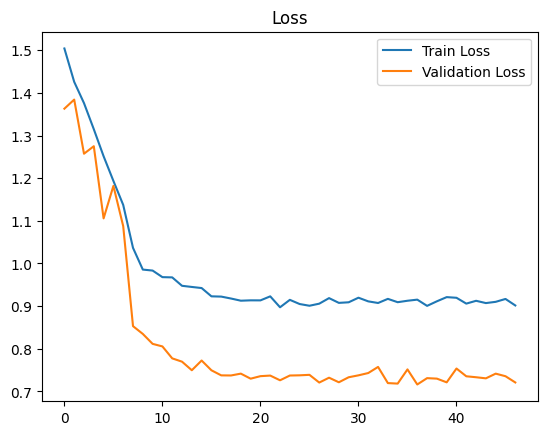

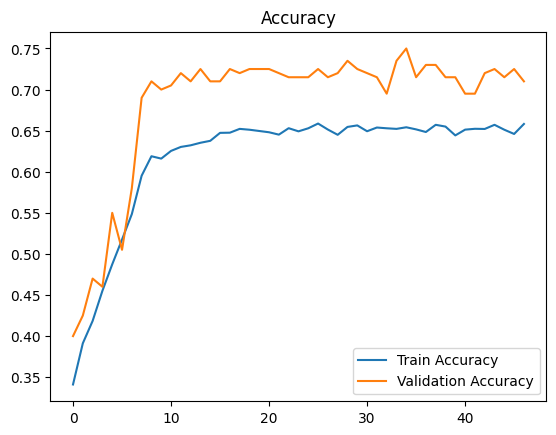

In [25]:
# Visualize the training history
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["valid_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["valid_acc"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Model Loading and Prediction

### This section includes two functions: one to load a pre-trained model and another to make predictions on a single image. The `load_model` function loads the saved model weights and prepares the model for evaluation by setting it to evaluation mode. The `predict_image` function preprocesses the input image, applies the necessary transformations, and uses the trained model to predict the class of the image. The result is the predicted class label based on the model’s output, mapped to the corresponding class name.


In [12]:
# Function to load a saved model
def load_model(path, num_classes):
    """
    Load a trained model from a saved file.
    
    Args:
    - path: Path to the saved model file.
    - num_classes: Number of output classes for the model.
    
    Returns:
    - model: The loaded and ready-to-use model.
    """
    # Initialize the model with the same number of output classes
    model = CustomResNet(num_classes=num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    # Set the model to evaluation mode to disable dropout and other training-specific layers
    model.eval()
    return model

# Function for making predictions on a single image
def predict_image(model, image_path, class_names):
    """
    Predict the class of a given image using a trained model.
    
    Args:
    - model: The trained model to use for predictions.
    - image_path: Path to the input image.
    - class_names: List of class names corresponding to model outputs.
    
    Returns:
    - Predicted class name for the input image.
    """
    # Define the transformations to preprocess the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load the image and convert it to RGB format
    image = Image.open(image_path).convert("RGB")
    # Apply transformations and add a batch dimension
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Disable gradient calculations for inference
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    return class_names[preds.item()]


In [20]:
# Example usage:
if __name__ == "__main__":
    class_names = ["apple", "banana", "grape", "mango", "strawberry"]
    saved_model_path = "fruit_classifier.pth"
    model = load_model(saved_model_path, num_classes=5)
    
    test_image_path = "./images/mango1.jpg" # Replace with the path to your test image
    prediction = predict_image(model, test_image_path, class_names)
    print(f"Predicted Class: {prediction}")

Predicted Class: mango


C:\Temp\ipykernel_16284\2413551224.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


# Image Segmentation and Classification

### This section defines a function, `segment_and_classify`, which performs two tasks on an input image: segmentation and classification. First, it uses a pre-trained segmentation model (like U-Net) to isolate the fruit in the image and refine the mask. Then, it passes the segmented image to a classification model (such as ResNet) to predict the type of fruit. 
### The result includes 
- the original image, 
- the segmented image,
- the predicted class.



C:\Temp\ipykernel_16284\2413551224.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


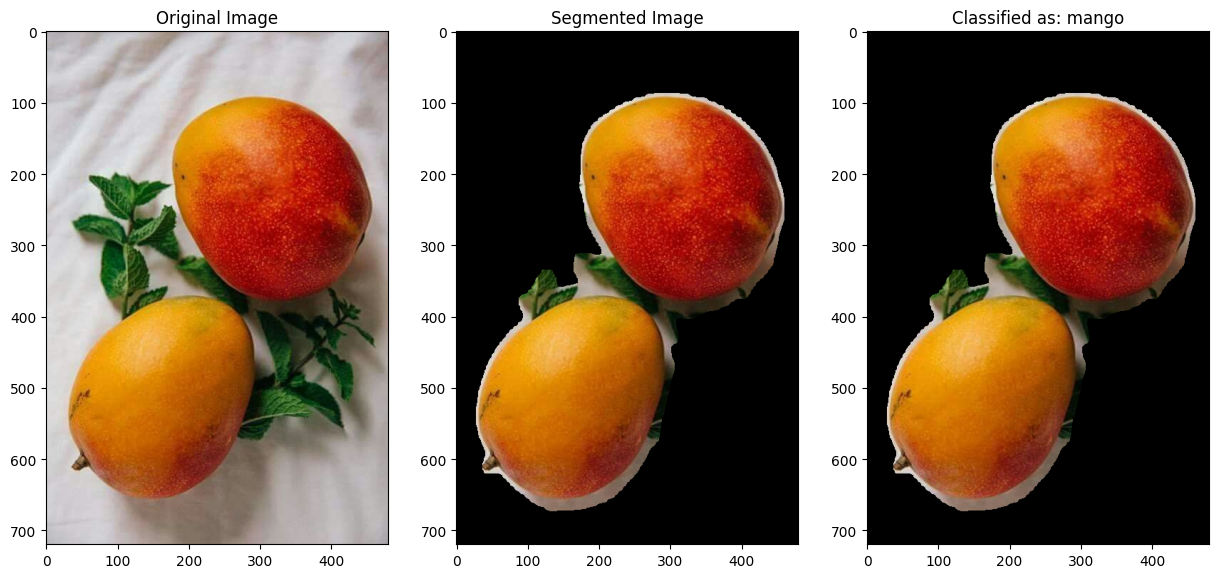

In [19]:
# Function to perform segmentation and classification on an image
def segment_and_classify(image_path, segmentation_model, classification_model, class_names):
    """
    Perform segmentation to isolate the fruit and classify its type.
    
    Args:
    - image_path (str): Path to the input image.
    - segmentation_model: Pre-trained segmentation model (e.g., U-Net).
    - classification_model: Pre-trained classification model (e.g., ResNet).
    - class_names (list): List of class names corresponding to classification model output.
    
    """
    # Step 1: Segmentation
    # Use the segmentation model to isolate the fruit and refine the mask
    final_image, refined_mask = process_image_with_mask(image_path, segmentation_model)
    
    # Step 2: Classification
    # The segmented image is passed to the classification model
    # Prepare a transformation pipeline to preprocess the image for the classifier
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Convert the segmented image into a format suitable for the classification model
    cropped_image = Image.fromarray(final_image.astype(np.uint8))
    input_tensor = transform(cropped_image).unsqueeze(0).to(device)
    
    # Predict the class using the classification model
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = classification_model(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    # Map the predicted class index to the class name
    predicted_class = class_names[preds.item()]
    
    # Visualization of the results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(load_img(image_path))
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(final_image.astype(np.uint8))
    plt.title("Segmented Image")
    
    plt.subplot(1, 3, 3)
    plt.imshow(final_image.astype(np.uint8))
    plt.title(f"Classified as: {predicted_class}")
    
    plt.show()

# Load pre-trained models
segmentation_model = tf.keras.models.load_model("unet_fruit_segmentation_model.h5")
classification_model = load_model("fruit_classifier.pth", num_classes=5)

# Perform segmentation and classification on a sample image
image_path = "./images/mango1.jpg"  # Path to the test image
segment_and_classify(image_path, segmentation_model, classification_model, 
                     ["apple", "banana", "grape", "mango", "strawberry"])
